In [2]:
import numpy as np
import pyuvdata
import matplotlib
import matplotlib.pyplot as plt
import os
import importlib
importlib.reload(pyuvdata)
from IPython.display import Image


In [93]:
import plot_delay_spectra
importlib.reload(plot_delay_spectra)

<module 'plot_delay_spectra' from '/home/rbyrne/rlb_hera/plot_delay_spectra.py'>

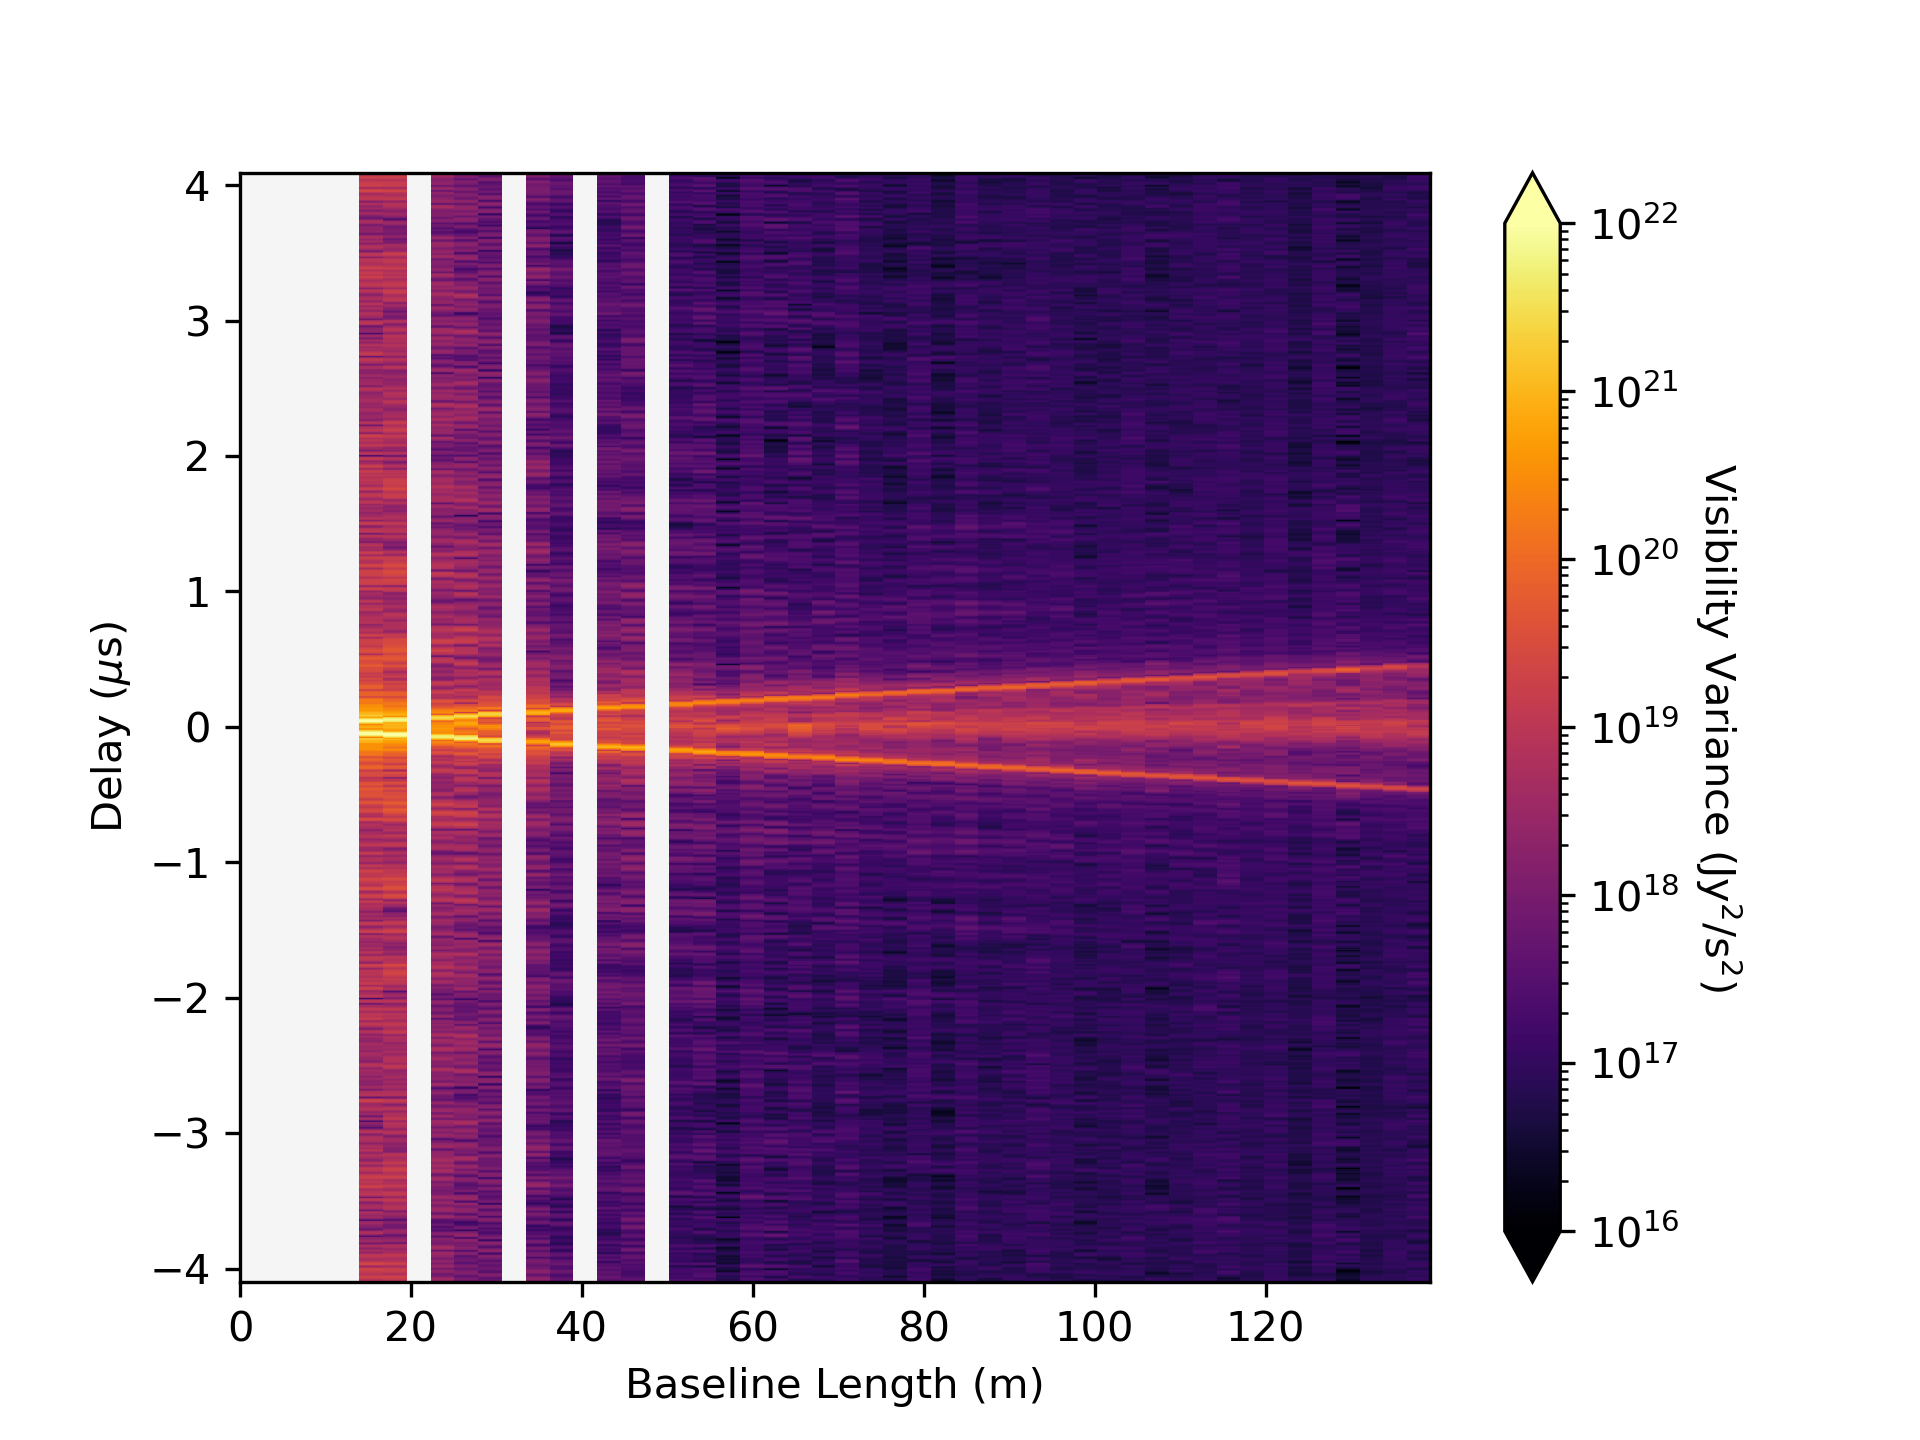

In [38]:
Image(
    filename=f"/safepool/rbyrne/hera_abscal_Jun2024/delay_spectrum_plots/zen.2459861.45004.sum.abs_calibrated.red_avg_data.png"
)

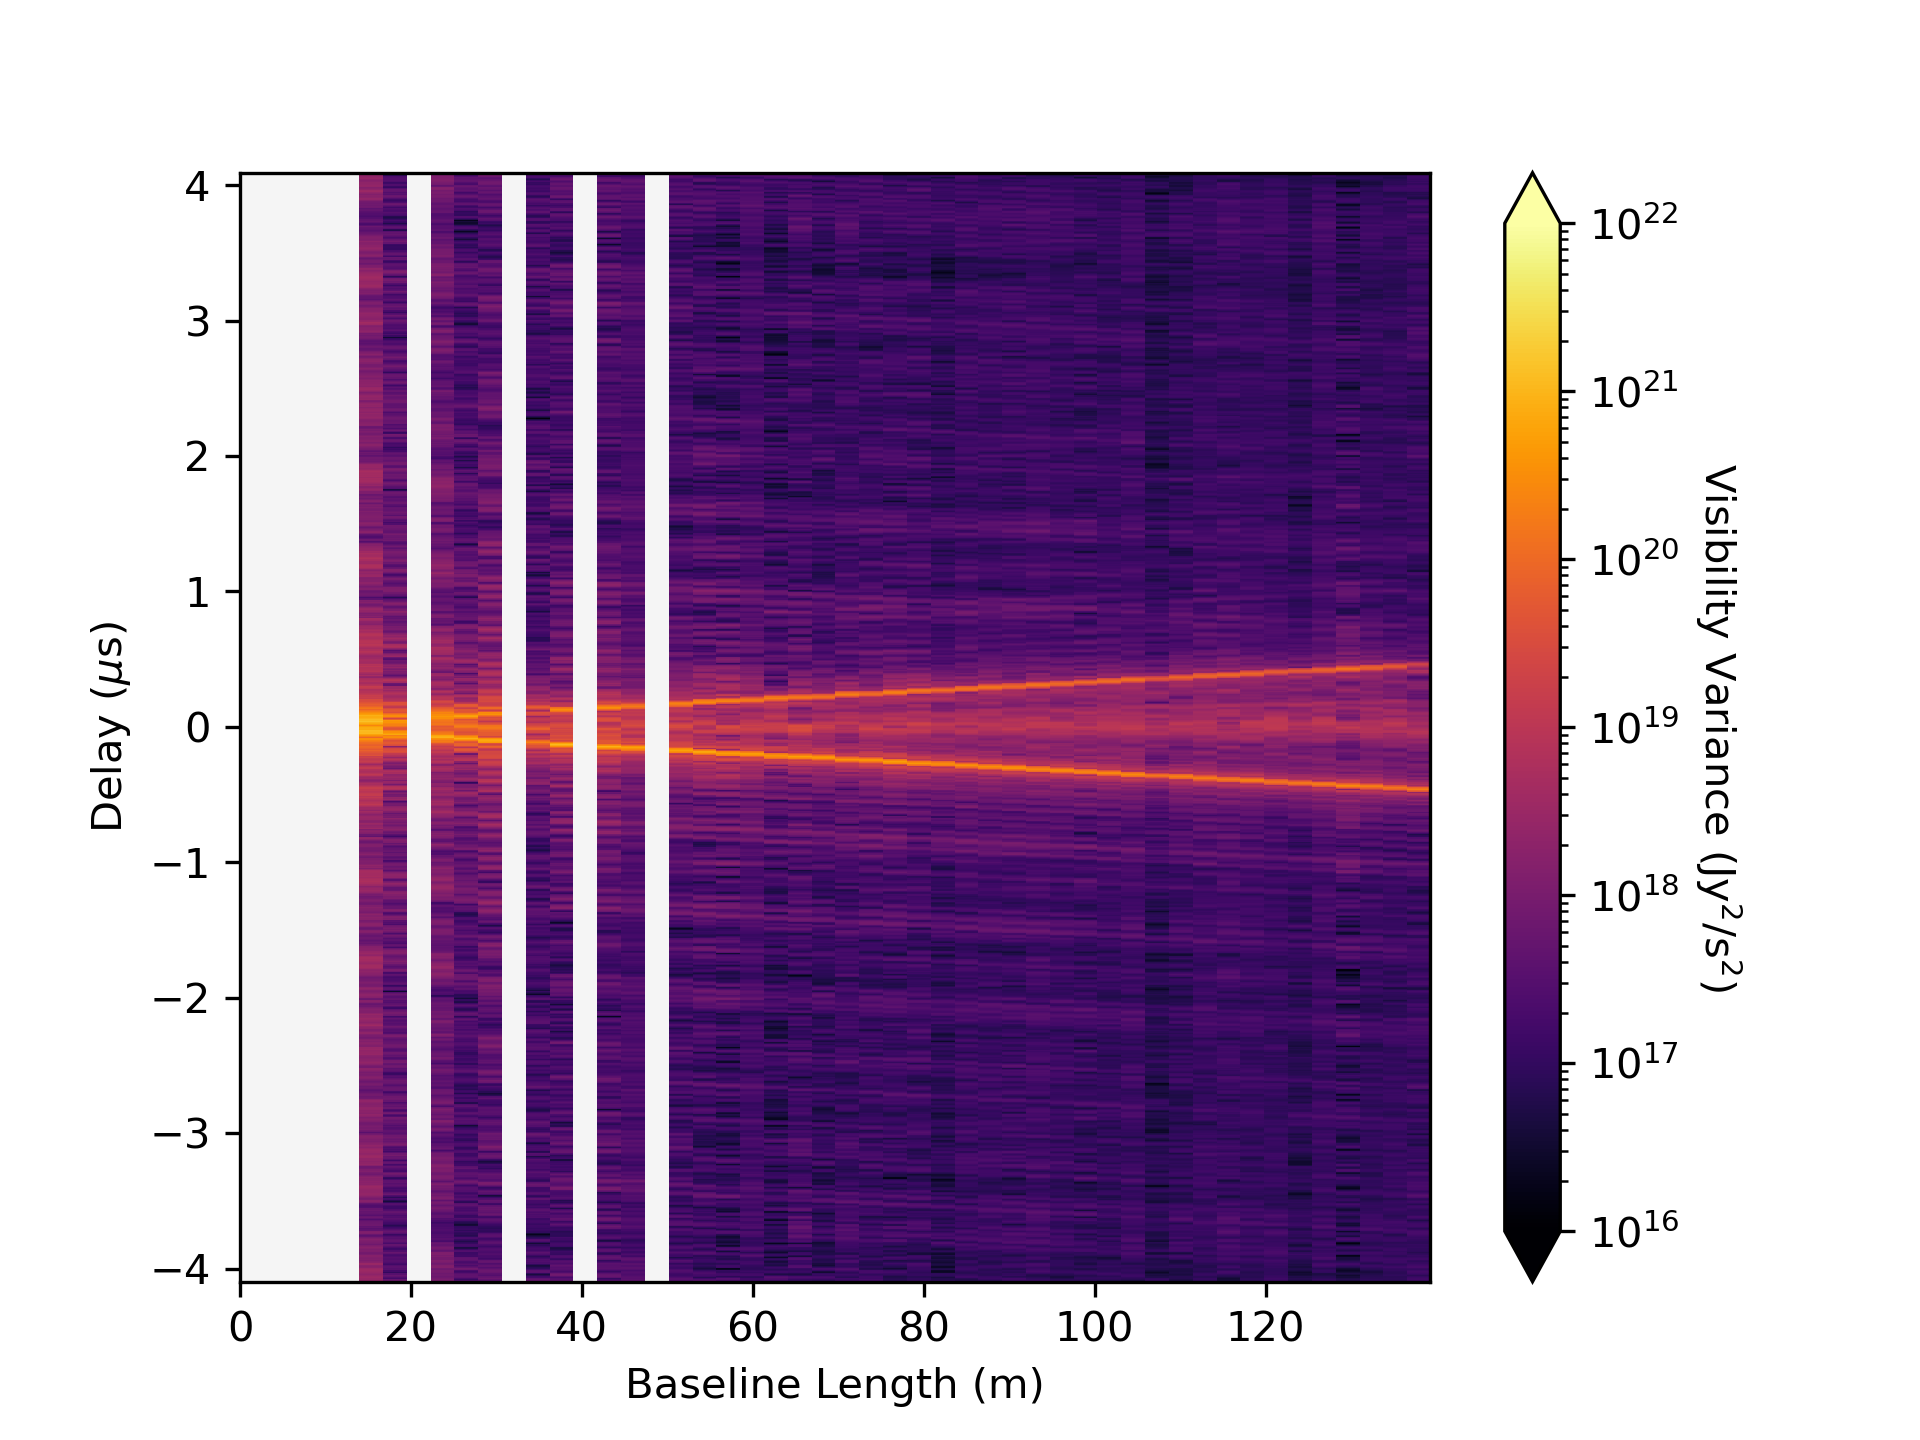

In [39]:
Image(
    filename=f"/safepool/rbyrne/hera_abscal_Jun2024/delay_spectrum_plots/zen.2459861.45004.sum.abs_calibrated.red_avg_diff.png"
)

In [73]:
data_orig = pyuvdata.UVData()
data_orig.read(
    "/safepool/rbyrne/hera_data/H6C-data/2459861/zen.2459861.45004.sum.abs_calibrated.red_avg.uvh5"
)
# model = pyuvdata.UVData()
# model.read("/safepool/rbyrne/hera_data/interpolated_models/zen.2459861.52096.sum.abs_calibrated.red_avg_model.uvfits")
data_abscal = pyuvdata.UVData()
data_abscal.read(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_abscal.uvfits"
)
data_dwabscal = pyuvdata.UVData()
data_dwabscal.read(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_dwabscal_normalized.uvfits"
)
# data.read("/safepool/rbyrne/hera_data/H4C-Abscal-Model/zen.2458894.16911.uvh5")

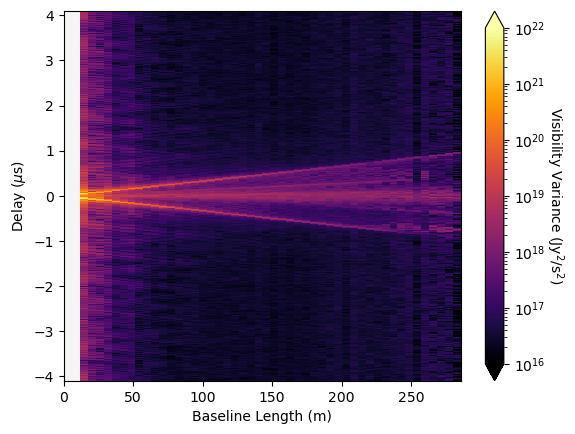

In [74]:
plot_delay_spectra.plot_visibilities(data_orig)

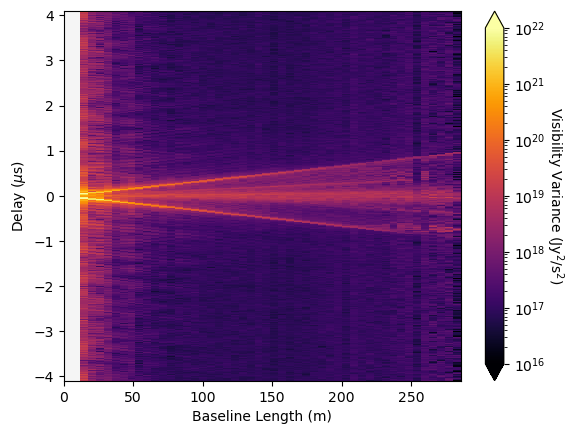

In [75]:
plot_delay_spectra.plot_visibilities(data_abscal)

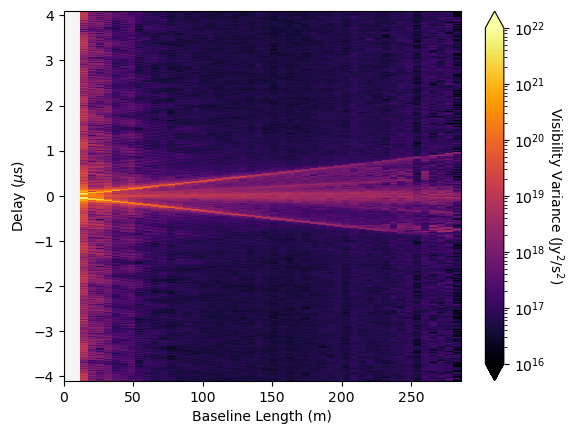

In [76]:
plot_delay_spectra.plot_visibilities(data_dwabscal)

In [77]:
# Normalize data
bl_bin_edges = np.linspace(0, 300, num=51)
delay_spectrum_dwabscal = plot_delay_spectra.calculate_delay_spectra(
    data_dwabscal, bl_bin_edges, use_polarization=-5
)
delay_spectrum_abscal = plot_delay_spectra.calculate_delay_spectra(
    data_abscal, bl_bin_edges, use_polarization=-5
)
data_dwabscal_normalized = data_dwabscal.copy()
print(np.nanmean(delay_spectrum_abscal))
print(np.nanmean(delay_spectrum_dwabscal))
data_dwabscal_normalized.data_array *= np.sqrt(np.nanmean(delay_spectrum_abscal) / np.nanmean(
    delay_spectrum_dwabscal
))

5.05815920175956e+18
2.754893452393933e+18


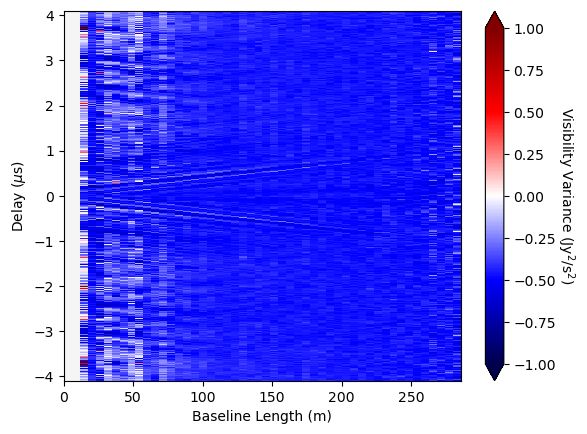

In [94]:
plot_delay_spectra.plot_difference(data_dwabscal, data_abscal, ratio=True)

In [70]:
dwabscal_params = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_dwabscal_params.npy"
)
abscal_params = np.load(
    "/safepool/rbyrne/hera_abscal_Jun2024/zen.2459861.45004.sum.abs_calibrated.red_avg_abscal_params.npy"
)

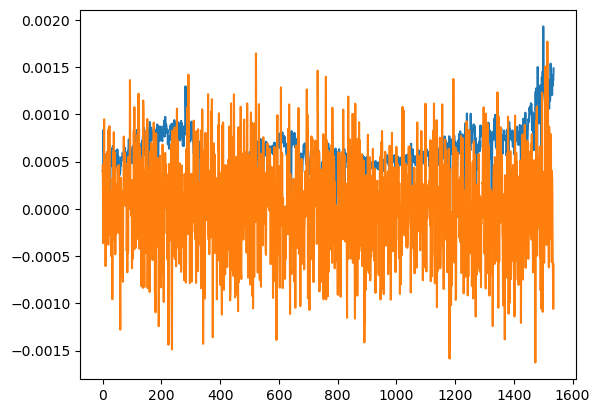

In [83]:
plt.plot(abscal_params[1,:,1])
plt.plot(dwabscal_params[1, :, 1])
#plt.ylim([0,1.3])
plt.show()

In [36]:
use_cmap = matplotlib.cm.get_cmap("inferno")
use_cmap.set_bad(color="whitesmoke")
vmin = 1e16
vmax = 1e22
norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
plt.imshow(
    avg_spectra["variance"].T,
    origin="lower",
    interpolation="none",
    cmap=use_cmap,
    norm=norm,
    aspect="auto",
)
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


NameError: name 'avg_spectra' is not defined

In [ ]:
abscal_params = np.load(
    "/safepool/rbyrne/hera_abscal/zen.2459861.48181.sum.abs_calibrated.red_avg_abscal_params.npy"
)

In [ ]:
np.shape(abscal_params)

(3, 1536, 2)

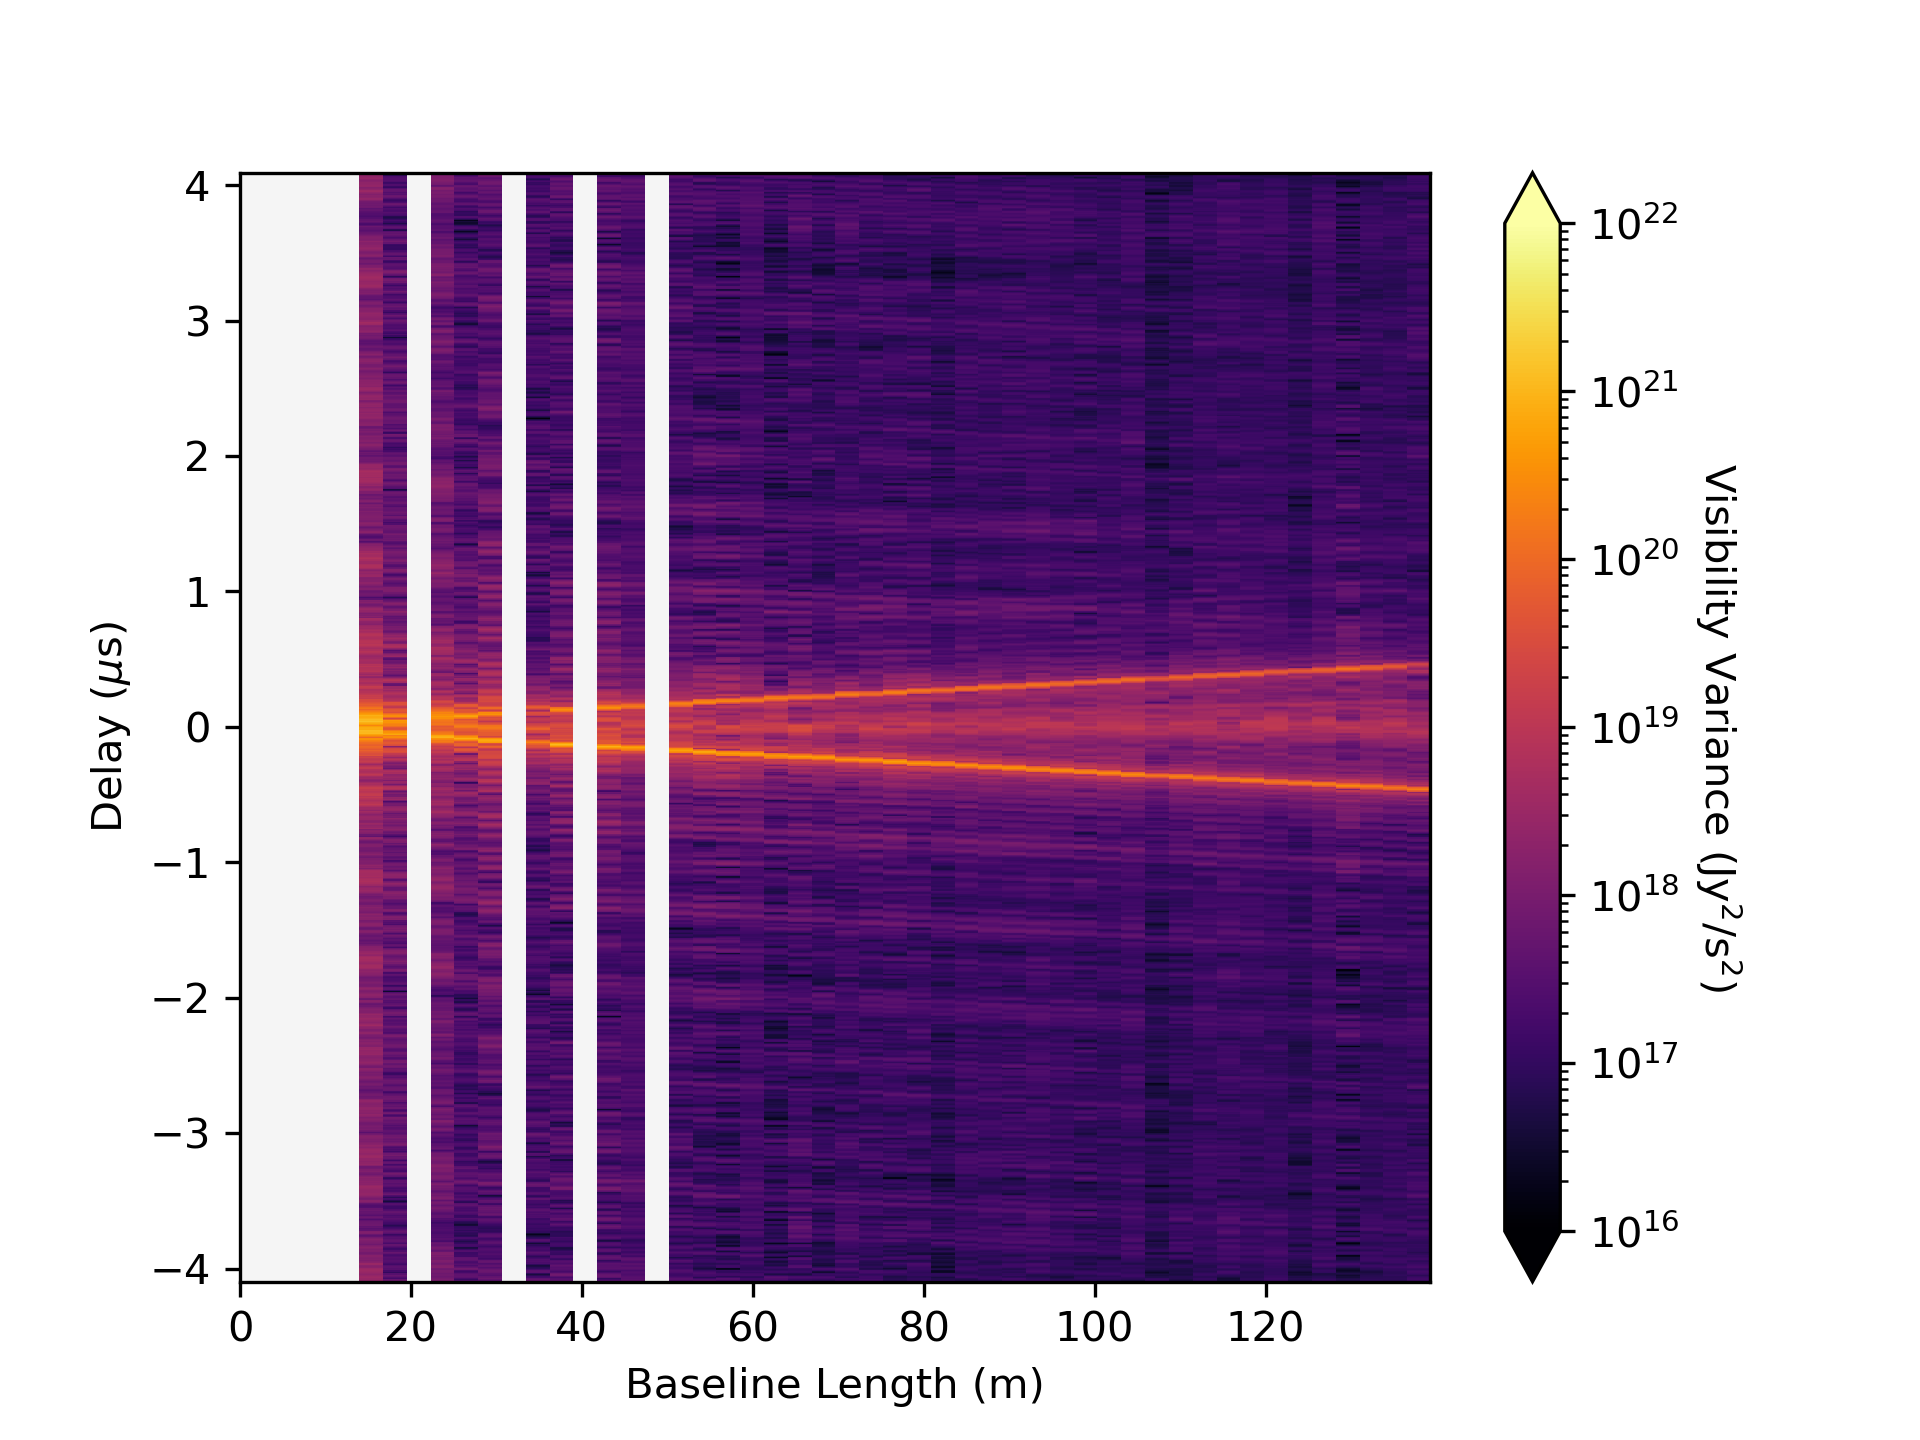

In [ ]:
from IPython.display import Image
Image(
    filename="/safepool/rbyrne/hera_abscal_Jun2024/delay_spectrum_plots/zen.2459861.45004.sum.abs_calibrated.red_avg_diff.png"
)